<div style="color:white;display:fill;border-radius:12px;
            background-color:#005bbb;font-size:190%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:gold;"><b>Assessment of Damage Associated with Russia's Invasion of Ukraine in 2022</b></p>
</div>

In [1]:
# Download all libraries needed for this project

%matplotlib inline 
import pandas as pd
import numpy as np
import folium as F
import json
import requests
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from io import BytesIO
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from math import log10, floor

# print('Matplotlib version: ', mpl.__version__)
# print(plt.style.available)
mpl.style.use(['ggplot'])

<div style="color:white;display:fill;border-radius:12px;
            background-color:#005bbb;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:gold;"><b> 1. Data Gathering</b></p>
</div>

Read the CSV files into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')
russian_equipment_adj = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment_correction.csv')
print('import complete'.title())

Import Complete


<div style="color:white;display:fill;border-radius:12px;
            background-color:#005bbb;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:gold;"><b> 2. Data Wrangling</b></p>
</div>

### Let's start by getting a basic understanding of the DataFrames and clean the data for analysis

In [3]:
russian_personnel

,date,day,personnel,personnel*,POW
0,2024-03-31,767,442170,about,NaN
1,2024-03-30,766,441520,about,NaN
2,2024-03-29,765,440790,about,NaN
3,2024-03-28,764,439970,about,NaN
4,2024-03-27,763,439190,about,NaN
...,...,...,...,...,...
761,2022-03-01,6,5710,about,200.0
762,2022-02-28,5,5300,about,0.0
763,2022-02-27,4,4500,about,0.0
764,2022-02-26,3,4300,about,0.0


In [4]:
russian_personnel.describe(include='all')

,date,day,personnel,personnel*,POW
count,766,766.000000,766.000000,766,62.000000
unique,766,NaN,NaN,2,NaN
top,2024-03-31,NaN,NaN,about,NaN
freq,1,NaN,NaN,760,NaN
mean,NaN,384.500000,175206.737598,NaN,386.387097
std,NaN,221.269444,128873.065029,NaN,131.440363
min,NaN,2.000000,2800.000000,NaN,0.000000
25%,NaN,193.250000,49575.000000,NaN,389.000000
50%,NaN,384.500000,161030.000000,NaN,421.000000
75%,NaN,575.750000,274830.000000,NaN,474.500000


In [5]:
#remove confusing columns
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
print("Done")

Done


In [6]:
# Set index to date
russian_personnel.set_index('date', inplace=True)
print("Done")

Done


In [7]:
# check to see if there are blank cells in the data
russian_personnel.isnull().describe().loc['top']

day    False
POW     True
Name: top, dtype: object

In [8]:
# fill empty rows with 0 and change data type
russian_personnel.fillna(0, inplace=True)
russian_personnel = russian_personnel.astype(int)[::-1]
print("Done")

Done


In [9]:
# replace blanks at the end of POW column with continuous count
last = 0
newpow = []
for i in russian_personnel['POW'].values:
    if last <= i:
        last = i
    elif last > i:
        i = last
    newpow.append(i)
russian_personnel['POW'] = newpow

# view clean data
russian_personnel.info()
russian_personnel

<class 'pandas.core.frame.DataFrame'>
Index: 766 entries, 2022-02-25 to 2024-03-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     766 non-null    int64
 1   POW     766 non-null    int64
dtypes: int64(2)
memory usage: 18.0+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200
...,...,...
2024-03-27,763,496
2024-03-28,764,496
2024-03-29,765,496


In [10]:
russian_equipment.info()
russian_equipment.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       766 non-null    object 
 1   day                        766 non-null    int64  
 2   aircraft                   766 non-null    int64  
 3   helicopter                 766 non-null    int64  
 4   tank                       766 non-null    int64  
 5   APC                        766 non-null    int64  
 6   field artillery            766 non-null    int64  
 7   MRL                        766 non-null    int64  
 8   military auto              65 non-null     float64
 9   fuel tank                  65 non-null     float64
 10  drone                      766 non-null    int64  
 11  naval ship                 766 non-null    int64  
 12  anti-aircraft warfare      766 non-null    int64  
 13  special equipment          747 non-null    float64

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles,submarines
0,2024-03-31,767,347,325,6966,13304,11050,1023,NaN,NaN,8731,26,743,1823.0,NaN,NaN,14717.0,2048.0,1.0
1,2024-03-30,766,347,325,6951,13284,11006,1023,NaN,NaN,8701,26,736,1814.0,NaN,NaN,14670.0,2046.0,1.0
2,2024-03-29,765,347,325,6922,13264,10991,1023,NaN,NaN,8656,26,735,1807.0,NaN,NaN,14645.0,2022.0,1.0
3,2024-03-28,764,347,325,6914,13237,10963,1021,NaN,NaN,8600,26,729,1800.0,NaN,NaN,14595.0,2017.0,1.0
4,2024-03-27,763,347,325,6904,13216,10931,1019,NaN,NaN,8578,26,728,1794.0,NaN,NaN,14539.0,2015.0,1.0
5,2024-03-26,762,347,325,6893,13207,10904,1019,NaN,NaN,8553,26,727,1789.0,NaN,NaN,14498.0,2014.0,1.0
6,2024-03-25,761,347,325,6887,13183,10877,1018,NaN,NaN,8539,26,726,1785.0,NaN,NaN,14454.0,2010.0,1.0
7,2024-03-24,760,347,325,6876,13158,10855,1018,NaN,NaN,8510,26,723,1778.0,NaN,NaN,14407.0,1992.0,1.0
8,2024-03-23,759,347,325,6852,13130,10811,1018,NaN,NaN,8463,26,723,1768.0,NaN,NaN,14344.0,1992.0,1.0
9,2024-03-22,758,347,325,6840,13111,10775,1018,NaN,NaN,8388,26,723,1749.0,NaN,NaN,14287.0,1953.0,1.0


In [11]:
russian_equipment_adj.info()
russian_equipment_adj

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     3 non-null      object 
 1   day                      3 non-null      int64  
 2   aircraft                 3 non-null      int64  
 3   helicopter               3 non-null      int64  
 4   tank                     3 non-null      int64  
 5   APC                      3 non-null      int64  
 6   field artillery          3 non-null      int64  
 7   MRL                      3 non-null      int64  
 8   drone                    3 non-null      int64  
 9   naval ship               3 non-null      int64  
 10  anti-aircraft warfare    3 non-null      int64  
 11  special equipment        3 non-null      int64  
 12  vehicles and fuel tanks  3 non-null      int64  
 13  cruise missiles          3 non-null      int64  
 14  submarines               1 non

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines
0,2022-10-13,231,0,0,0,-25,32,0,20,1,0,0,0,0,NaN
1,2023-05-27,458,3,2,-5,7,8,2,49,0,0,0,11,31,NaN
2,2023-10-03,587,-1,0,5,0,0,0,-1,0,0,0,0,0,0.0


In [12]:
# checking the rows to be corrected in the original dataset
russian_equipment[russian_equipment['date'].isin(list(russian_equipment_adj['date']))]

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles,submarines
180,2023-10-03,587,315,316,4732,9008,6565,801,NaN,NaN,5080,20,540,943.0,NaN,NaN,8932.0,1529.0,1.0
309,2023-05-27,458,310,296,3799,7442,3406,572,NaN,NaN,2941,18,329,449.0,NaN,NaN,6172.0,1025.0,NaN
535,2022-10-13,232,268,240,2511,5167,1556,357,NaN,NaN,1182,16,183,140.0,NaN,Kramatorsk and Kryvyi Rih,3935.0,316.0,NaN


In [13]:
# merge equipment cells to account for corrections in counts
merged_df=pd.merge(russian_equipment, russian_equipment_adj, on='date', how='left')
merged_df.fillna(0, inplace=True)

# Add the numerical values from common columns together
common_columns=list(russian_equipment_adj.columns.drop(['day','date']))
for col in common_columns:
    if col + '_x' in merged_df.columns and col + '_y' in merged_df.columns:
        merged_df[col] = merged_df[col + '_x'] + merged_df[col + '_y']

# Drop the original columns after adding their values
merged_df.drop([col + '_x' for col in common_columns] 
               + [col + '_y' for col in common_columns]
               + ['day_y'], axis=1, inplace=True)

# Check to see if data is corrected
merged_df[merged_df['date'].isin(list(russian_equipment_adj['date']))]

,date,day_x,military auto,fuel tank,mobile SRBM system,greatest losses direction,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines
180,2023-10-03,587,0.0,0.0,0.0,0,314.0,316.0,4737.0,9008.0,6565.0,801.0,5079.0,20.0,540.0,943.0,8932.0,1529.0,1.0
309,2023-05-27,458,0.0,0.0,0.0,0,313.0,298.0,3794.0,7449.0,3414.0,574.0,2990.0,18.0,329.0,449.0,6183.0,1056.0,0.0
535,2022-10-13,232,0.0,0.0,0.0,Kramatorsk and Kryvyi Rih,268.0,240.0,2511.0,5142.0,1588.0,357.0,1202.0,17.0,183.0,140.0,3935.0,316.0,0.0


In [14]:
# corrected data used to replace original equipment data
russian_equipment = merged_df[::-1]

russian_equipment.head(10)

,date,day_x,military auto,fuel tank,mobile SRBM system,greatest losses direction,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines
765,2022-02-25,2,100.0,60.0,0.0,0,10.0,7.0,80.0,516.0,49.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
764,2022-02-26,3,130.0,60.0,0.0,0,27.0,26.0,146.0,706.0,49.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
763,2022-02-27,4,130.0,60.0,0.0,0,27.0,26.0,150.0,706.0,50.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
762,2022-02-28,5,291.0,60.0,0.0,0,29.0,29.0,150.0,816.0,74.0,21.0,3.0,2.0,5.0,0.0,0.0,0.0,0.0
761,2022-03-01,6,305.0,60.0,0.0,0,29.0,29.0,198.0,846.0,77.0,24.0,3.0,2.0,7.0,0.0,0.0,0.0,0.0
760,2022-03-02,7,355.0,60.0,0.0,0,30.0,31.0,211.0,862.0,85.0,40.0,3.0,2.0,9.0,0.0,0.0,0.0,0.0
759,2022-03-03,8,374.0,60.0,0.0,0,30.0,31.0,217.0,900.0,90.0,42.0,3.0,2.0,11.0,0.0,0.0,0.0,0.0
758,2022-03-04,9,404.0,60.0,0.0,0,33.0,37.0,251.0,939.0,105.0,50.0,3.0,2.0,18.0,0.0,0.0,0.0,0.0
757,2022-03-05,10,409.0,60.0,0.0,0,39.0,40.0,269.0,945.0,105.0,50.0,3.0,2.0,19.0,0.0,0.0,0.0,0.0
756,2022-03-06,11,447.0,60.0,0.0,0,44.0,48.0,285.0,985.0,109.0,50.0,4.0,2.0,21.0,0.0,0.0,0.0,0.0


In [15]:
russian_equipment.describe(include='all')

,date,day_x,military auto,fuel tank,mobile SRBM system,greatest losses direction,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines
count,766,766.000000,766.000000,766.000000,766.000000,766.0,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000,766.00000,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000
unique,766,NaN,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022-02-25,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,384.500000,88.887728,5.882507,0.185379,NaN,275.496084,261.370757,3487.677546,6882.237598,3755.723238,535.447781,2981.10705,17.060052,325.761097,516.557441,6047.433420,884.848564,0.261097
std,NaN,221.269444,321.715517,19.453562,0.838358,NaN,64.467385,68.090738,1754.884842,3080.212128,3131.903139,283.125440,2418.35376,4.871853,209.678451,513.688010,3703.770933,637.745970,0.439519
min,NaN,2.000000,0.000000,0.000000,0.000000,NaN,10.000000,7.000000,80.000000,516.000000,49.000000,4.000000,0.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,193.250000,0.000000,0.000000,0.000000,NaN,236.000000,206.000000,2053.750000,4437.250000,1149.500000,294.000000,864.75000,15.000000,156.000000,106.250000,3278.500000,203.500000,0.000000
50%,NaN,384.500000,0.000000,0.000000,0.000000,NaN,304.000000,289.000000,3488.000000,6794.000000,2523.500000,498.500000,2126.00000,18.000000,261.000000,256.500000,5372.000000,907.000000,0.000000
75%,NaN,575.750000,0.000000,0.000000,0.000000,NaN,315.000000,316.000000,4642.500000,8889.000000,6167.000000,784.000000,4856.00000,20.000000,528.000000,911.750000,8685.000000,1507.500000,1.000000


In [16]:
#set index for sorting by date.
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 766 entries, 2022-02-25 to 2024-03-31
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day_x                      766 non-null    int64  
 1   military auto              766 non-null    float64
 2   fuel tank                  766 non-null    float64
 3   mobile SRBM system         766 non-null    float64
 4   greatest losses direction  766 non-null    object 
 5   aircraft                   766 non-null    float64
 6   helicopter                 766 non-null    float64
 7   tank                       766 non-null    float64
 8   APC                        766 non-null    float64
 9   field artillery            766 non-null    float64
 10  MRL                        766 non-null    float64
 11  drone                      766 non-null    float64
 12  naval ship                 766 non-null    float64
 13  anti-aircraft warfare      766 non-null

In [17]:
# Taking a closer look at column data to assess its usefullness
russian_equipment['greatest losses direction'].unique()

array([0, 'Sievierodonetsk', 'Kurakhove and Izyum',
       'Zaporizhzhia and Izyum', 'Izyum', 'Izyum, Novopavlivsk',
       'Popasna', 'Lyman and Kurakhove', 'Slobozhanskyi', 'Novopavlivsk',
       'Avdiivka', 'Novopavlivsk, Kurakhove and Sievierodonetsk',
       'Kurakhove', 'Kurakhove and Avdiivka', 'Bakhmut and Zaporizhzhia',
       'Lyman and Zaporizhzhia', 'Sloviansk, Kryvyi Rih and Zaporizhzhia',
       'Bakhmut', 'Lyman', 'Avdiivka and Kryvyi Rih', 'Zaporizhzhia',
       'Kryvyi Rih and Zaporizhzhia', 'Kryvyi Rih and Bakhmut',
       'Sloviansk', 'Kharkiv and Bakhmut', 'Sievierodonetsk and Bakhmut',
       'Bakhmut and Sievierodonetsk', 'Sloviansk, Bakhmut and Kryvyi Rih',
       'Bakhmut and Avdiivka', 'Sloviansk, Bakhmut and Avdiivka',
       'Sloviansk and Bakhmut', 'Bakhmut and Kurakhove',
       'Kramatorsk and Bakhmut', 'Sloviansk and Donetsk',
       'Avdiivka and Bakhmut', 'Kramatorsk', 'Mykolaiv',
       'Kramatorsk, Kryvyi Rih and Bakhmut', 'Kryvyi Rih', 'Donetsk',
   

In [18]:
# Set the pandas option to suppress the warning *update later*
pd.set_option('mode.chained_assignment', None)

# Consolidating repetitive columns (according to the dataset updates) and deleting blank ones
russian_equipment.loc[:,'vehicles and fuel tanks'] += (russian_equipment.loc[:,'fuel tank'] 
                                             + russian_equipment.loc[:,'military auto'])
russian_equipment.loc[:,'cruise missiles'] += russian_equipment.loc[:,'mobile SRBM system']

russian_equipment.drop(columns={'fuel tank', 'military auto', 'mobile SRBM system'
                                , 'greatest losses direction'}, inplace=True)
russian_equipment.rename({'day_x':'day'}, axis=1, inplace=True)

#Change all remaining numeric data to type integer
russian_equipment = russian_equipment.astype(int)
russian_equipment.info()
russian_equipment

<class 'pandas.core.frame.DataFrame'>
Index: 766 entries, 2022-02-25 to 2024-03-31
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   day                      766 non-null    int64
 1   aircraft                 766 non-null    int64
 2   helicopter               766 non-null    int64
 3   tank                     766 non-null    int64
 4   APC                      766 non-null    int64
 5   field artillery          766 non-null    int64
 6   MRL                      766 non-null    int64
 7   drone                    766 non-null    int64
 8   naval ship               766 non-null    int64
 9   anti-aircraft warfare    766 non-null    int64
 10  special equipment        766 non-null    int64
 11  vehicles and fuel tanks  766 non-null    int64
 12  cruise missiles          766 non-null    int64
 13  submarines               766 non-null    int64
dtypes: int64(14)
memory usage: 89.8+ KB


,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines
date,,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,0,2,0,0,160,0,0
2022-02-26,3,27,26,146,706,49,4,2,2,0,0,190,0,0
2022-02-27,4,27,26,150,706,50,4,2,2,0,0,190,0,0
2022-02-28,5,29,29,150,816,74,21,3,2,5,0,351,0,0
2022-03-01,6,29,29,198,846,77,24,3,2,7,0,365,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,763,347,325,6904,13216,10931,1019,8578,26,728,1794,14539,2015,1
2024-03-28,764,347,325,6914,13237,10963,1021,8600,26,729,1800,14595,2017,1
2024-03-29,765,347,325,6922,13264,10991,1023,8656,26,735,1807,14645,2022,1


### Categorizing equipment based on type.

In [19]:
air_units = ['drone','aircraft','helicopter', 'cruise missiles']
water_units = ['naval ship', 'submarines']
ground_units = ['APC','vehicles and fuel tanks', 'tank', 'field artillery', 'MRL',  'anti-aircraft warfare', 'special equipment']

## Acronyms
* POW -  Prisoner of War
* MRL -  Multiple Rocket Launcher
* APC -  Armored Personnel Carrier
* SRBM - Short-range ballistic missile
<!-- * UAV -  Unmanned Aerial Vehicle -->
<!-- * RPA -  Remotely Piloted Vehicle -->

<div style="color:white;display:fill;border-radius:12px;
            background-color:#005bbb;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:gold;"><b> 3. Exploratory Data Analysis and Visualization</b></p>
</div>

## Problem 1
##### Visually represent the region being invaded.

In [20]:
# Define the coordinates for Ukraine and create the map
ukraine_lat = 48.383022
ukraine_long = 31.1828699
ukraine_map = F.Map(location=[ukraine_lat, ukraine_long], 
                    tiles="cartodbpositron", zoom_start=6.49)

# Create a feature group for Kiev
kiev = F.FeatureGroup()

kiev_lat = 50.4500336
kiev_long = 30.5241361
kiev.add_child(F.CircleMarker([kiev_lat, kiev_long], radius=5, color="red", fill_color="blue"))
ukraine_map.add_child(kiev)

F.Marker([kiev_lat, kiev_long], popup="Ukraine's Capital City").add_to(ukraine_map)

# Read GeoJSON data for Ukraine from file
with open('/kaggle/input/world-countries/world-countries.json', 'r') as geojson_file:
    ukraine_geojson = json.load(geojson_file)

# Add the GeoJSON data to the map
F.GeoJson(ukraine_geojson, name='ukraine', style_function=
          lambda x: {"fillColor": "yellow", "color": "blue"}).add_to(ukraine_map)

print("Navigable World Map with Kyiv (Ukraine's capital) highlighted".upper())
ukraine_map

NAVIGABLE WORLD MAP WITH KYIV (UKRAINE'S CAPITAL) HIGHLIGHTED


## Problem 2
##### Show the total Prisoners of War per day recorded in the Personel table.


In [21]:
# Refine data to extract on the columns needed for this table
pow_data = russian_personnel[["day", "POW"]]

# create figure
fig=go.Figure()

fig.add_trace(go.Scatter(x=pow_data.index, y=pow_data['POW']))

# set title
fig.update_layout(title={'text':'Total Prisoners of War Held to Date'.title(),
                         'y':0.93,'x':0.5,'xanchor':'center','yanchor':'top'})

# Add range slider for customized search results
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="todate"),
                dict(count=7, label="1wk", step="day", stepmode="todate"),
                dict(count=30, label="1mth", step="month",stepmode="todate"),
                dict(step="all")]), 
            bgcolor='blue'),
        rangeslider=dict(visible=True),
        type="date"))

fig.update_layout(plot_bgcolor='#f1f3f4')
fig.show()

## Problem 3
##### What is the daily change in POW and compared to Total POW?

In [22]:
# Helper Variables
last = 0
increase = []

# Calculate daily change in POW
for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
    
# Assign new values to table    
pow_data['Daily Increase in Prisoners of War'] = increase

# Style table
pow_data_ = pow_data[['day', 'POW', 'Daily Increase in Prisoners of War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily Total Prisoners of War'}, inplace=True)

pow_data_.head(25)

,Daily Total Prisoners of War,Daily Increase in Prisoners of War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
7,200,0
8,200,0
9,200,0
10,216,16


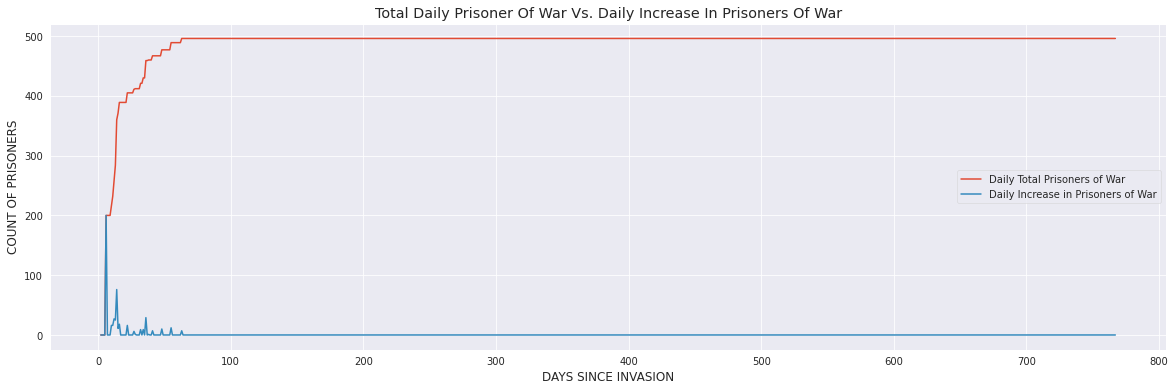

In [23]:
# Set graph style
sns.set_style('darkgrid')

# Create graph
pow_data_.plot(figsize=(20,6))
plt.xlabel('Days since Invasion'.upper())
plt.ylabel('Count of Prisoners'.upper())
plt.title("Total Daily Prisoner of War VS. Daily Increase in Prisoners of War".title())
plt.show()

## Problem 4
##### Visualize the daily change in POW.

count    18.000000
mean     16.444444
std      16.905350
min       1.000000
25%       7.500000
50%      11.500000
75%      17.500000
max      76.000000
Name: Daily Increase in Prisoners of War, dtype: float64


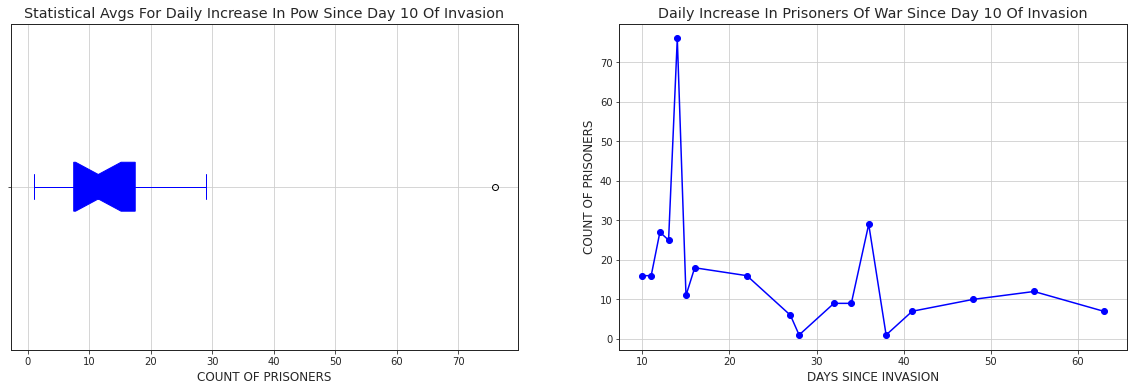

In [24]:
sns.set_style('ticks')

# Create Plot Object
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Assessing data after day 10 when POW is within a more narrow/normalized range. See above graph
plot_data1=pow_data_['Daily Increase in Prisoners of War'][pow_data_['Daily Increase in Prisoners of War'] > 0][1:]
print(plot_data1.describe())

# Subplot 1: Box plot
plot_data1.plot(kind='box', color='blue', figsize=(20, 6), vert=False, ax=ax0, notch=True, label="", 
                grid=True, patch_artist=True) 
ax0.set_title(f'Statistical Avgs for Daily Increase in POW since day {plot_data1.index[0]} of Invasion'.title())
ax0.set_xlabel('Count of Prisoners'.upper())

# Subplot 2: Line plot
plot_data1.plot(color='blue', figsize=(20,6), ax=ax1, marker="o", grid=True)
ax1.set_xlabel('Days since Invasion'.upper())
ax1.set_ylabel('Count of Prisoners'.upper())
ax1.set_title(f"Daily Increase in Prisoners of War since day {plot_data1.index[0]} of Invasion".title())

# Print graph
plt.show()

In [25]:
print(f'There are {round(plot_data1.describe()[1])} average daily prisoners of war between day {plot_data1.index.min()} and {plot_data1.index.max()} of the invasion. No additional prisoners have been reported since.')

There are 16 average daily prisoners of war between day 10 and 63 of the invasion. No additional prisoners have been reported since.


## Problem 5
##### What Is the total daily loss for all equipment used in the invasion?

In [26]:
# Structure data from dataset
daily_total_equip_loss = russian_equipment.reset_index()
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)

# Create new dataframe for graph object
daily_total_equip_loss['Daily Total Equipment Loss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))
daily_total_equip_loss[['Daily Total Equipment Loss']]

,Daily Total Equipment Loss
day,
2,828
3,1152
4,1157
5,1480
6,1580
...,...
763,60423
764,60575
765,60764


In [27]:
# Create and show graph
plot_data2 = daily_total_equip_loss[['Daily Total Equipment Loss']]

fig=px.scatter(plot_data2, x=plot_data2.index, y='Daily Total Equipment Loss', marginal_x='box', 
               color='Daily Total Equipment Loss', labels={
                   'Daily Total Equipment Loss':'Daily Total Equipment Loss'.upper()
                   ,'day':'day'.upper()})

fig.update_layout(plot_bgcolor='rgb(241,246,255)',
                  title={'text':f'Total Equipment Lost since day {plot_data2.index[0]} of the invasion'
                         .title(),'y':0.93,'x':0.45,'xanchor':'center','yanchor':'top'})

fig.show()

## Problem 6
##### Create a word map to show the equipment types with the highest total loss of all the equipment used.

In [28]:
sns.set_style('white')

# Get the most recent loss data
total = int(daily_total_equip_loss.iloc[-1: , -1:].values)

# gather data pertaining to the total equipment lost and generate a count of the equipment lost by type
total_loss = daily_total_equip_loss.iloc[-1: , :-1]
total_loss.reset_index(inplace=True)
total_loss = pd.DataFrame(total_loss.drop('day', axis=1).transpose()).reset_index()
total_loss.rename(columns={'index':'Equipment', 0:'Count'}, inplace=True)
total_loss.set_index('Equipment', inplace=True)
total_loss.sort_values(by='Count', inplace=True)

total_loss

,Count
Equipment,
submarines,1
naval ship,26
helicopter,325
aircraft,347
anti-aircraft warfare,743
MRL,1023
special equipment,1823
cruise missiles,2048
tank,6966


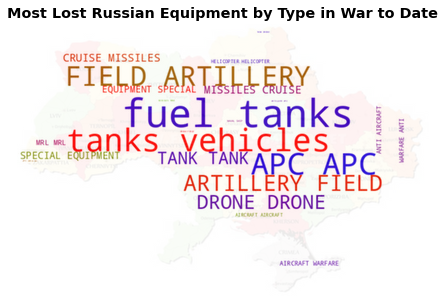

In [29]:
# duplicate equipment name based on how much they contribute to total loss in the shape of the Ukraine map
word_string=""
max_words = total_loss.mean()
for equipment in total_loss.index:
     times_repeat = int(total_loss.loc[equipment, 'Count']/total * max_words)
     word_string = word_string.upper() + ((equipment + " ") * times_repeat)

# create image of Ukraine map
response = requests.get("https://www.freeworldmaps.net/europe/ukraine/map-ukraine.jpg")
ukraine_mask = np.array(Image.open(BytesIO(response.content)))

# create word cloud
word_cloud = WordCloud(background_color = 'white', colormap='brg', mask=ukraine_mask).generate(word_string)

# Display cloud
plt.figure(figsize=(13,5))
plt.imshow(word_cloud, interpolation='bessel', alpha=1)
plt.imshow(ukraine_mask, cmap=plt.cm.gray, interpolation='bessel', alpha=0.1)
plt.title('Most Lost Russian Equipment by Type in War to Date', fontweight='bold', color='black')
plt.axis('off')

plt.show()

## Problem 7
##### How much equipment did Russia lose in the first 5 days of the invasion?

In [30]:
# Getting count of total looses as of day 5 when the values started to be recorded
dt5 = daily_total_equip_loss.head(4).drop('Daily Total Equipment Loss', axis=1)

# Create pie chart chowing loss ratio
dict_rl_sum = dt5.sum(axis=0)[1:]
fig = go.Figure(data=[go.Pie(labels=dict_rl_sum.keys()
                             , values=dict_rl_sum.values
                             , textinfo='label'
                             , insidetextorientation='auto'
                )])
chart_title = ('Cumulative Equipment Lost in the First 5 Days: '
               + russian_equipment.index[0] + " to " + russian_equipment.index[3])
fig.update_layout(title={'text':chart_title,'y':0.85,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()
daily_total_equip_loss.head(4)

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines,Daily Total Equipment Loss
day,,,,,,,,,,,,,,
2,10,7,80,516,49,4,0,2,0,0,160,0,0,828
3,27,26,146,706,49,4,2,2,0,0,190,0,0,1152
4,27,26,150,706,50,4,2,2,0,0,190,0,0,1157
5,29,29,150,816,74,21,3,2,5,0,351,0,0,1480


## Problem 8
##### What is the most recent count of Russian equipment loss?

In [31]:
#Preparing data for charts
def input_unit(unit_name):
    if unit_name in air_units:
        return "Air Units"
    elif unit_name in water_units:
        return "Water Units"
    else:
        return "Ground Units"

new_df = russian_equipment.tail(1).transpose().reset_index()
new_df.columns = ['equipment_name', 'unit_amount']
new_df = new_df.drop([0], axis=0)

# performing data manipulation, inputing categorized unit type into a new column
new_df['unit_type'] = new_df['equipment_name'].apply(lambda x: input_unit(x))

# Creating Sunburst chart based on air, ground or naval unit type
fig = px.sunburst(
        new_df, path=['unit_type', 'equipment_name', 'unit_amount'], maxdepth=2
        , color='unit_type', values='unit_amount', color_continuous_scale='BdRu'
        , title='Total Equipment Loss As At: ' + russian_equipment.index[-1] + ' (Most Recent Data)'
                )
fig.update_layout(title={'y':.9,'x':0.5,'xanchor':'center','yanchor':'top'})

fig.show()

new_df.groupby(['unit_type', 'equipment_name']).sum().sort_values(by=['unit_type','unit_amount'], ascending=[False, True])

unit_amount
unit_type    equipment_name                      
Water Units  submarines                         1
             naval ship                        26
Ground Units anti-aircraft warfare            743
             MRL                             1023
             special equipment               1823
             tank                            6966
             field artillery                11050
             APC                            13304
             vehicles and fuel tanks        14717
Air Units    helicopter                       325
             aircraft                         347
             cruise missiles                 2048
             drone                           8731

## Problem 9
##### Is there any correlation between the POW and equipment loss?

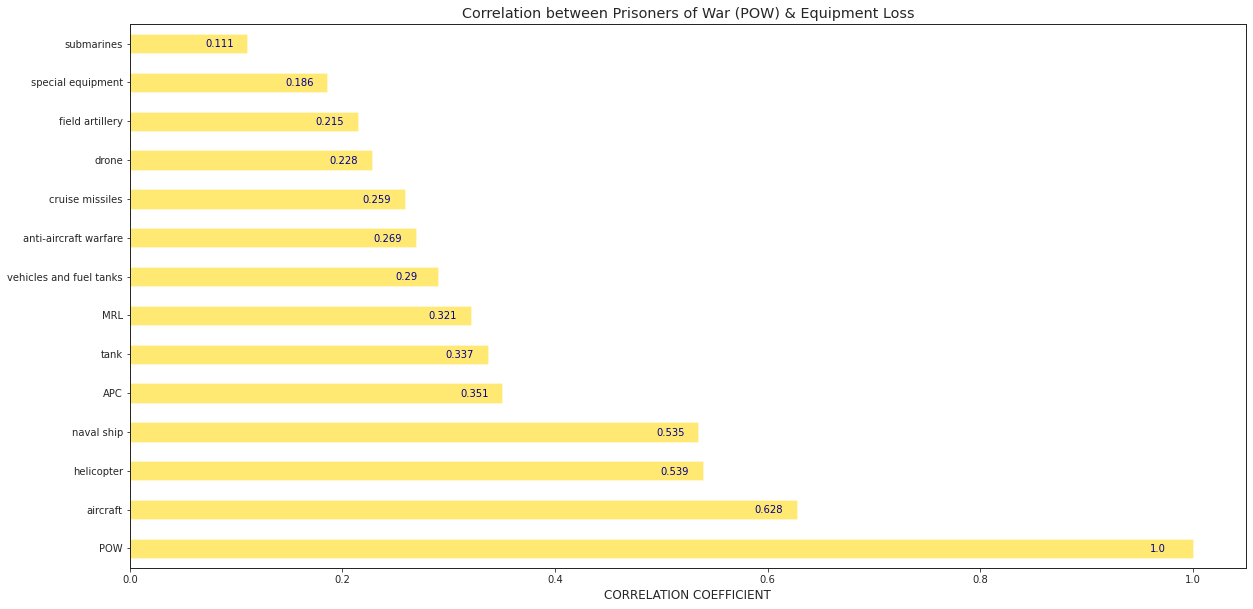

In [32]:
sns.set_style('ticks')

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(20,10), alpha=.55, color='gold'
                ).axvline(x=0, color='grey',linestyle='--', linewidth=1, alpha=0.2)

for index, value in enumerate(merged):
    value = round(value, 3)
    label = format(value)
    if value>0:
        value-=.04
        color='darkblue'
    else:
        value+=.003
        color='crimson'
    plt.annotate(label, xy=(value, index-.1), color=color, alpha=1)
    
plt.xlabel('Correlation Coefficient'.upper())
plt.show()

In [33]:
print('Correlation stats for POW and Equipment'.upper())
merged.describe()

CORRELATION STATS FOR POW AND EQUIPMENT


count    14.000000
mean      0.376177
std       0.231536
min       0.110703
25%       0.235804
50%       0.305094
75%       0.488812
max       1.000000
Name: POW, dtype: float64

<div style="color:white;display:fill;border-radius:12px;
            background-color:#005bbb;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:gold;"><b> 4. Summary of Findings</b></p>
</div>

## Problem 10
##### What inferences can you make from the relationship between POW and Equipment lost?

In [34]:
m = merged.describe()
k = merged.keys()
v = merged.values
rank = total_loss.set_index([pd.Index(range(1, len(total_loss) +1))])[total_loss.index.str.startswith(k[1])].index[0]
sd=round(m[2], 3)
s=''
if sd>1:
    s='high, and indicates that the there is much variability in the data; all points seem to be far from the mean or average correlation.'
else:
    s='low, and indicates that the there is not much variability in the data; all points seem to be close to the mean or average correlation.'

In [35]:
conclusion = print(
 f"\t There is an overall strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. \
 From the above data, it is evident that as the POW increases so does the overall equipment loss. The strength in \
 correlation, ranges from {round(v[1], 3)} ({k[1]}) to {round(v[-1], 3)} ({k[-1]}). It should be noted that the \
 strongest correlation exists not between the equipmet type with the highest loss({total_loss.index[-1]}) but with \
 the type that ranked as having the {rank}th highest loss of all {len(total_loss.index)} equipment types assessed. \
 The median correlation is {round(m[-3], 3)}; falling between {k[6]} and {k[7]}. The standard deviation is {sd} \
 which is {s} The last record of prisoners of war was on day {plot_data1.index.max()} of the invasion, and the last \
 record of equipment lost was on day {pow_data_.index[-1]}. \n\n\t \
 It is then valid to conclude that as the invasion continues, and POW increases, so will {k[1]}s lost at a \
 minimum rate of {round(m[1], 1)}:1.0 when compared to Prisoners of War. \n\n\t \
 #PeaceForUkraine"
    )
conclusion

	 There is an overall strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss.  From the above data, it is evident that as the POW increases so does the overall equipment loss. The strength in  correlation, ranges from 0.628 (aircraft) to 0.111 (submarines). It should be noted that the  strongest correlation exists not between the equipmet type with the highest loss(vehicles and fuel tanks) but with  the type that ranked as having the 4th highest loss of all 13 equipment types assessed.  The median correlation is 0.305; falling between MRL and vehicles and fuel tanks. The standard deviation is 0.232  which is low, and indicates that the there is not much variability in the data; all points seem to be close to the mean or average correlation. The last record of prisoners of war was on day 63 of the invasion, and the last  record of equipment lost was on day 767. 

	  It is then valid to conclude that as the invasion continues, and POW increases, so 

<div style="color:white;display:fill;border-radius:12px;
            background-color:#005bbb;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:gold;"><b>- Thank you -</b></p>
</div>
